# Fisher Matrix for Global 21-cm Signal

In [4]:
import numpy as np
import ares
from scipy import interpolate
import matplotlib.pyplot as plt
import time

In [5]:
def data_matrix(nu, params):
    ### 1- A matrix for saving the data: M.shape= (1+3*npar, lennu)
    #         first row: nu, len(nu) = lennu
    #         next 2: first parameter's 2 neighbors
    #         next 2: second parameter's 2 neighbors ...
    # returns an array of interpolated dTb as a func. of nu 
    ####################################################################
    sim = ares.simulations.Global21cm(**params, verbose=False)     # Initialize a simulation object
    sim.run() 
    x = sim.history['nu']
    y = sim.history['dTb']
    f = interpolate.interp1d(x, y)
    return f(nu)

def derivative_matrix(mat, step):
    ### 2- A function to take derivative matrix consisted of:
    #         first row: nu
    #         2nd row: derivative wr/ first parameter 
    #         3rd row: derivative wr/ second parameter  ...
#############################################################
    row = mat.shape[0]
    deriv = mat[0]
    for i in range(row):
        if i>1 & i%2==0:
            stp_i = np.int((i-2)/2)
            nrow = (mat[i+1,:]-mat[i,:])/2/step[stp_i]
            deriv = np.vstack((deriv,nrow))        
    return deriv

def Fisher_elements(der_mat, sigma):
    ### 3- A function to calculate the Fisher elements using 
    ### the 21-cm formula. 
    ##########################################################
    p_num = der_mat.shape[0]
    Fish = np.zeros([p_num,p_num])
    for i in range(p_num):
        for j in range(p_num):
            cross = np.multiply(der_mat[i],der_mat[j]) / sigma**2
            Fish[i,j] = np.sum(cross)
    return Fish

def DataDict(nu, fid_dict, step_dict):
    # returns a dictionary with these rows:
    # 1,2: frequency and the fiducial temp
    # 2i+1,2i+2: temp(par+) and temp(par-), e.g. T(fX+-step) 
    ##########################################################
    DD = {}
    DD["nu"] = nu                                     #row1
    DD["Fiducial"] = data_matrix(nu_test, fid_dict)    #row2
    for name in fid_dict:
        parss = fid_dict.copy()
#         print(parss)
        dlabel = name+"+"                                        # +run row 2i+1
        parss.update({name: fid_dict[name]+step_dict[name]})
        DD[dlabel] = data_matrix(nu_test, parss)
#         print(parss)
        dlabel = name+"-"                                        # -run row 2i+2
        parss.update({name: fid_dict[name]-step_dict[name]})
        DD[dlabel] = data_matrix(nu_test, parss) 
#         print(parss, "\n")
    return DD

def DerivDict(datadict, fid_dict, step_dict):
    
    ##########################################################
    partial = {}
    partial["nu"] = datadict["nu"] 
    
    for name in fid_dict:
        parss = fid_dict.copy()
#         print(parss)
        ul = name + "+"                                        # +label 
        dl = name + "-"                                        # -label
#         print(name, ul,dl,step_dict[name])
        deriv = (datadict[ul] - datadict[dl]) / 2. / step_dict[name]
        partial[name] = deriv
#         print("derivative finished", "\n")
    return partial

def NoiseFunction(nu, T408, nu408, beta, dnu, tobs):
    #################################################
    # dnu in Hz, tobs in s, nu in MHz               #
    #################################################
    Tsky = T408 * (nu / nu408)**(beta)
    sigma = Tsky / np.sqrt(2*tobs*dnu)
    return sigma

In [8]:
# fid_dict =  {'fesc': .1,    'fX': 1.0}
# step_dict = {'fesc': 0.001, 'fX': 1e-6}
fid_dict =  {'fX': 1.0,  'fstar': 0.1,  'Nion': 4000.0, 'Nlw': 9690.0, 'Tmin': 10000.0}
step_dict = {'fX': 1e-6, 'fstar': 1e-4, 'Nion': 100.0, 'Nlw': 1e-5, 'Tmin': 1.0}
nu_test = np.linspace(5, 230, 1000)

sig = 10 #mK
# sig = 10*nu_test/nu_test #mK
noise = NoiseFunction(nu_test, T408=20, nu408=408, beta=-2.55, dnu=1000, tobs=1000*3600)


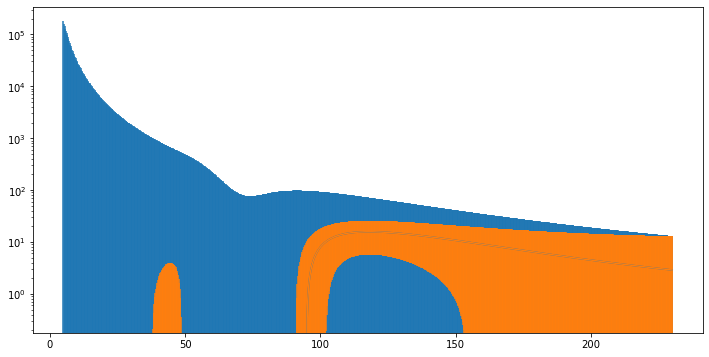

In [44]:
plt.subplots(figsize=(12,6))

# plt.plot(nu_test,noise*1000)
# plt.xlabel("nu",fontsize=15);plt.ylabel("Noise (mK)",fontsize=15)
# plt.grid();plt.savefig("noise.pdf")

plt.errorbar(datadict["nu"], datadict["Fiducial"], yerr=1000*noise1, label = "Fiducial")
plt.errorbar(datadict["nu"], datadict["Fiducial"], yerr=10, label = "Fiducial")
plt.yscale("log")

# noise1 = NoiseFunction(nu_test, T408=20, nu408=408, beta=-2.55, dnu=1000, tobs=10*3600)
# noise2 = NoiseFunction(nu_test, T408=20, nu408=408, beta=-2.55, dnu=1000, tobs=100*3600)
# noise3 = NoiseFunction(nu_test, T408=20, nu408=408, beta=-2.55, dnu=1000, tobs=1000*3600)
# noise4 = NoiseFunction(nu_test, T408=1000, nu408=408, beta=-2.55, dnu=1000, tobs=100*3600)
# noise5 = NoiseFunction(nu_test, T408=1000, nu408=408, beta=-2.55, dnu=1000, tobs=1000*3600)

# plt.plot(nu_test, 1000*noise1, label = "T408=20k, tobs=10hr")
# plt.plot(nu_test, 1000*noise2, label = "T408=20k, tobs=100hr")
# plt.plot(nu_test, 1000*noise3, label = "T408=20k, tobs=1000hr")
# plt.plot(nu_test, 1000*noise4, label = "T408=1000k, tobs=100hr")
# plt.plot(nu_test, 1000*noise5, label = "T408=1000k, tobs=1000hr")

# plt.plot(nu_test, 10*noise/noise, label = "10 mK const noise")

# plt.xlabel("frequency (MHz)"); plt.ylabel("Noise (mK)")
# plt.yscale("log");plt.grid(); plt.legend();plt.savefig("noise_curves.pdf")

In [41]:
(8)**(2.55)

200.8535290615681

In [17]:
time0 = time.time()
datadict = DataDict(nu_test, fid_dict, step_dict)
# plt.plot(testdatadict["nu"], testdatadict["Fiducial"])
print("--- %s seconds ---" % (time.time() - time0))
print(datadict.keys())

--- 38.28561091423035 seconds ---
dict_keys(['nu', 'Fiducial', 'fX+', 'fX-', 'fstar+', 'fstar-', 'Nion+', 'Nion-', 'Nlw+', 'Nlw-', 'Tmin+', 'Tmin-'])


In [18]:
time0 = time.time()
derivdict = DerivDict(datadict, fid_dict, step_dict)
print("--- %s seconds ---" % (time.time() - time0))
print(derivdict.keys())

--- 0.0003037452697753906 seconds ---
dict_keys(['nu', 'fX', 'fstar', 'Nion', 'Nlw', 'Tmin'])


In [47]:
# plt.plot(derivdict["nu"], derivdict["fX"])
# plt.plot(derivdict["nu"], derivdict["fstar"])

In [48]:
# plt.subplots(figsize=(12,6))
# plt.plot(datadict["nu"], datadict["fX+"], label = "fX+")
# plt.plot(datadict["nu"], datadict["fX-"], label = "fX-")
# plt.plot(datadict["nu"], datadict["Fiducial"], label = "Fiducial")
# plt.grid(); plt.legend();plt.xlabel("nu",fontsize=15);plt.ylabel("dTb (mK)",fontsize=15)

In [49]:
# ## change needed!
# ##Note: no j!. i have to use "fX+" etc...

# fig, ax = plt.subplots(nrows=2 ,ncols=5 ,figsize=(20,8), sharex=True)
# # datadict.shape
#     `
# ax[0,0].set_ylabel("$\delta$T", fontsize=15)
# ax[1,0].set_ylabel("$\delta$T/ $\delta$T(fid)-1", fontsize=15)
# for i in range(5):
#     for j in range(2):
#         if j==0:
#             ax[j,i].plot(datadict['nu'],datadict[1], "k", label='fiducial')
#             ax[j,i].plot(datadict['nu'],datadict[i+2], "b", label=str(names[i])+"+"+str(steps[i]))
#             ax[j,i].plot(datadict['nu'],datadict[i+3], "r", label=str(names[i])+"-"+str(steps[i]))
#             ax[j,i].fill_between(datadict[0], datadict[1]-sig, datadict[1]+sig, alpha = 0.4, label = '10mK error')
#             ax[j,i].set_title(str(names[i]), fontsize=20)
#             ax[j,i].grid()
#             ax[j,i].legend()
#         else:
#             ax[j,i].plot(datadict[0],((datadict[i+2]-datadict[1])), "b", label=str(names[i])+"+"+str(steps[i]))
#             ax[j,i].plot(datadict[0],((datadict[i+3]-datadict[1])), "r", label=str(names[i])+"-"+str(steps[i]))
#             ax[j,i].set_xlabel("Frequency (MHz)", fontsize=15)
#             ax[j,i].grid()
#             ax[j,i].legend()

# plt.savefig("residuals.pdf")

# print(par_fid)

In [50]:
# derMM = derivative_matrix(MM, steps)

# plt.subplots(figsize=(10,6))

# MM.shape
# plt.xlabel("nu",fontsize=15);plt.ylabel("derivatives",fontsize=15)
# plt.plot(derMM[0],derMM[1], "r")
# plt.plot(derMM[0],derMM[2], "b")
# # plt.plot(derMM[0],derMM[3], "r")
# # plt.plot(derMM[0],derMM[4], "b")
# # plt.plot(derMM[0],derMM[5], "k") 
# plt.grid()

generating new axis
['fX', 'fstar', 'Nion', 'Nlw', 'Tmin']


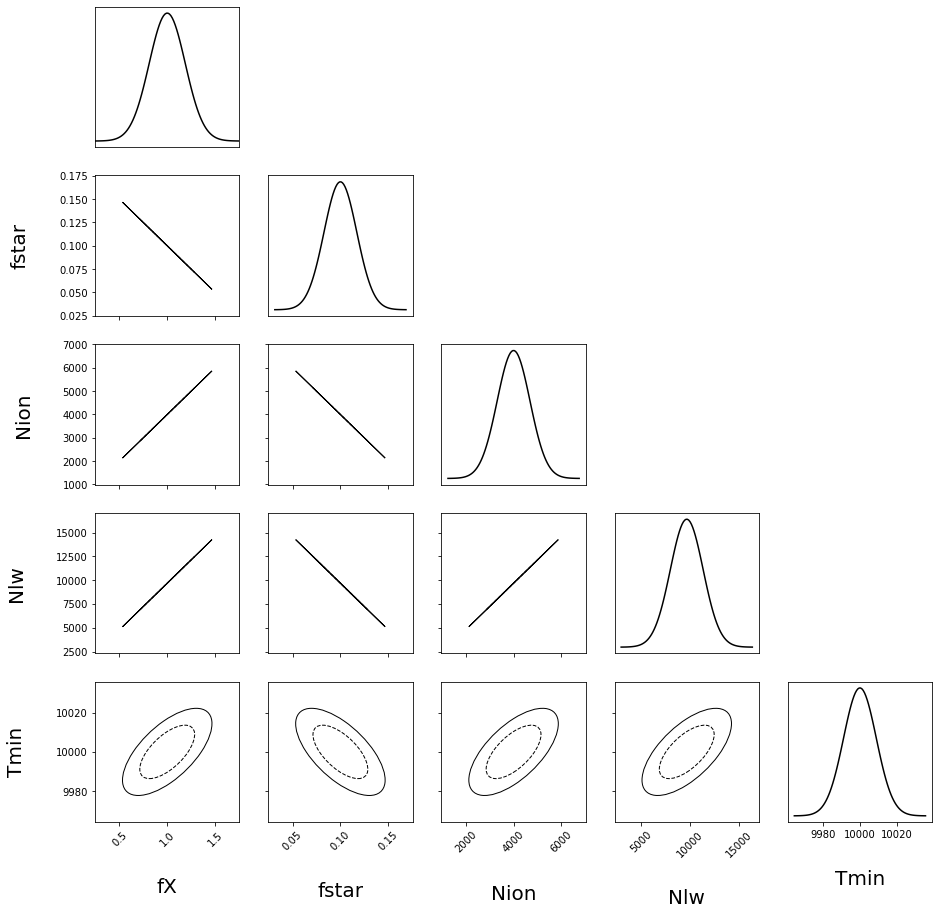

In [35]:
orderedNames = list(fid_dict.keys())
fids = list(fid_dict.values())

Derivemat = np.array([derivdict[i] for i in orderedNames])

### Fisher Matrix
FisherMatrix = Fisher_elements(Derivemat, noise1)
# print(FisherMatrix)
from fishchips.cosmo import Observables 
import fishchips.util

cov = np.linalg.inv(FisherMatrix)
# cov
# obs = Observables(parameters=names,fiducial=fids,left=fids-steps,right=fids+steps)

fishchips.util.plot_triangle_base(orderedNames, fids, cov, labels=orderedNames, fig_kwargs={'figsize': (15, 15)},
                                 xlabel_kwargs={'labelpad': 30, 'fontsize':20},
                                 ylabel_kwargs={'labelpad': 30, 'fontsize':20})
plt.savefig('triangle.pdf')

In [36]:
for i in range(5):
    print(orderedNames[i], "\t", fids[i], "\t", np.round(np.sqrt(cov[i,i]),4))

fX 	 1.0 	 0.1887
fstar 	 0.1 	 0.0188
Nion 	 4000.0 	 753.1438
Nlw 	 9690.0 	 1842.0893
Tmin 	 10000.0 	 8.9613


In [55]:
# ### Fisher Matrix
# FisherMatrix = Fisher_elements(derMM, sig)
# print(FisherMatrix)
# from fishchips.cosmo import Observables
# import fishchips.util

# cov = np.linalg.inv(FisherMatrix)
# cov
# # obs = Observables(parameters=names,
# #                   fiducial=fids,
# #                   left=fids-steps,
# #                   right=fids+steps)

# fishchips.util.plot_triangle_base(names, fids, cov, labels=names, fig_kwargs={'figsize': (8, 8)},
#                                  xlabel_kwargs={'labelpad': 30, 'fontsize':20},
#                                  ylabel_kwargs={'labelpad': 30, 'fontsize':20},
#                                  scales=[1,1,1e-5,1e-4,1e-4])
# plt.savefig('triangle.pdf')

# Testing the derivatives to choose the best stepsize

In [168]:
fXsteps = np.logspace(-8,0,9)
# arr1 = np.logspace(-15,-1,15)
# arr2 = np.logspace(-1,0,6)
# fXsteps = np.concatenate((arr1,arr2), axis=0)

fid_dict1 = {'fX': 1.0}
step_dict = {'fX': 0.3}
nu_test = np.linspace(5, 230, 1000)
fXsteps

array([1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01,
       1.e+00])

In [169]:
time0 = time.time()

stability = {}
for i, step in enumerate(fXsteps):
    step_dict['fX'] = step
    datadict1  = DataDict(nu_test,    fid_dict1, step_dict)
    derivdict1 = DerivDict(datadict1, fid_dict1, step_dict)
    if i==0:
        stability['nu'] = derivdict1['nu']
    stability[str(step)] = derivdict1['fX']
    
print("--- %s seconds ---" % (time.time() - time0))


--- 92.48414206504822 seconds ---


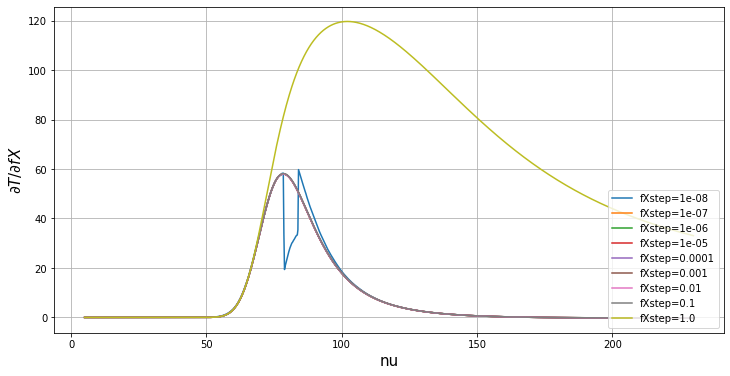

In [183]:
plt.subplots(figsize=(12,6))

for i,step in enumerate(stability):
#     print(i,step)
    if i>0:
        plt.plot(stability['nu'], stability[str(step)], label= "fXstep=" + str(step))

plt.grid();plt.xlabel("nu",fontsize=15);plt.ylabel("$\partial T / \partial fX$",fontsize=15)
plt.savefig("deriv_nu_fX.pdf"); plt.legend(loc='lower right')

0 5.0
50 16.26126126126126
100 27.52252252252252
150 38.78378378378378
200 50.04504504504504
250 61.306306306306304
300 72.56756756756756
350 83.82882882882883
400 95.09009009009009
450 106.35135135135135
500 117.61261261261261
550 128.8738738738739
600 140.13513513513513
650 151.3963963963964
700 162.65765765765767
750 173.91891891891893
800 185.18018018018017
850 196.44144144144144
900 207.7027027027027
950 218.96396396396398


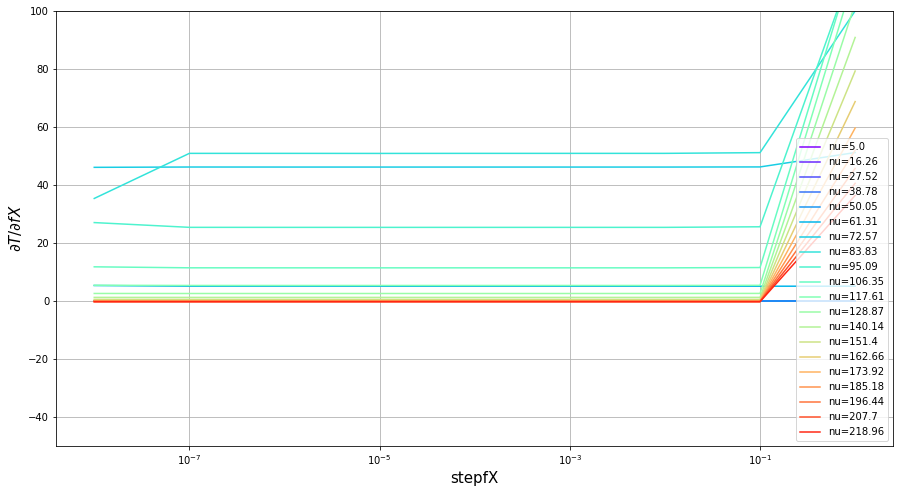

In [181]:
plt.subplots(figsize=(15,8))
cmap=plt.get_cmap("rainbow")

matmat = stability['nu']
for i,step in enumerate(stability):
#     print(i,step)
    if i>0:
        matmat = np.vstack((matmat,stability[str(step)]))

matmat = np.delete(matmat,0,0)

for j in range(len(stability['nu'])):
            if j%50 == 0:
                print(j, stability['nu'][j])
                color = cmap((stability['nu'][j]-min(stability['nu']))/(max(stability['nu'])-min(stability['nu'])))
                label = "nu="+str(np.round(stability['nu'][j],2))
                plt.plot(fXsteps, matmat[:,j], label = label, color = color)
                
plt.grid();plt.xlabel("stepfX",fontsize=15);plt.ylabel("$\partial T / \partial fX$",fontsize=15)
plt.xscale("log"); plt.legend(loc='lower right');plt.ylim([-50, 100])
plt.savefig("deriv_step_fX.pdf")

In [174]:
# plt.subplots(figsize=(15,8))
# cmap=plt.get_cmap("rainbow")

# matmat = stability['nu']
# for i,step in enumerate(stability):
# #     print(i,step)
#     if i>0:
#         matmat = np.vstack((matmat,stability[str(step)]))

# matmat = np.delete(matmat,0,0)

# # fXstepz = np.delete(fXsteps, 15)
# # print(fXstepz)

# for j in range(len(stability['nu'])):
#             if j%50 == 0:
#                 print(j, stability['nu'][j])
#                 color = cmap((stability['nu'][j]-min(stability['nu']))/(max(stability['nu'])-min(stability['nu'])))
#                 label = "nu="+str(np.round(stability['nu'][j],2))
#                 plt.plot(fXstepz, matmat[:,j], label = label, color = color)
                
# plt.grid();plt.xlabel("stepfX",fontsize=15);plt.ylabel("$\partial T / \partial fX$",fontsize=15)
# plt.xscale("log"); plt.legend(loc='upper left');plt.ylim([-5, 60])
# plt.savefig("deriv_step_fX.pdf")

In [68]:
# plt.subplots(figsize=(12,6))

# for i,step in enumerate(stability):
# #     print(i,step)
#     if i>0:
#         for j in range(len(stability['nu'])):
#             if j%100 == 0:
#                 print(j, stability['nu'][j])
#                 plt.plot(stability['nu'], stability[str(step)], label= "fXstep=" + str(step))

# plt.grid(); plt.legend();plt.xlabel("fX",fontsize=15);plt.ylabel("$\partial T / \partial fX$",fontsize=15)
# plt.savefig("deriv_stability.pdf")

In [31]:
arr1 = np.array([1,2,3])
arr2 = np.array([24,31,23])
np.concatenate((arr1,arr2), axis=0)
np.delete(arr1,1)
arr1

array([1, 2, 3])

# Best stepsize fstar


In [94]:
# arr1 = np.logspace(-15,-1,15)
# arr2 = np.logspace(-1,0,6)
# fstr_steps = np.concatenate((arr1,arr2), axis=0)
fstr_steps = np.logspace(-6,-1,15)

fid_dict1 = {'fstar': 0.1}
step_dict = {'fstar': 0.1}
nu_test = np.linspace(5, 230, 500)
print(fstr_steps)

time0 = time.time()

stability = {}
for i, step in enumerate(fstr_steps):
    step_dict['fstar'] = step
    datadict1  = DataDict(nu_test,    fid_dict1, step_dict)
    derivdict1 = DerivDict(datadict1, fid_dict1, step_dict)
    if i==0:
        stability['nu'] = derivdict1['nu']
    stability[str(step)] = derivdict1['fstar']
    
print("--- %s seconds ---" % (time.time() - time0))

[1.00000000e-06 2.27584593e-06 5.17947468e-06 1.17876863e-05
 2.68269580e-05 6.10540230e-05 1.38949549e-04 3.16227766e-04
 7.19685673e-04 1.63789371e-03 3.72759372e-03 8.48342898e-03
 1.93069773e-02 4.39397056e-02 1.00000000e-01]
--- 152.0347719192505 seconds ---


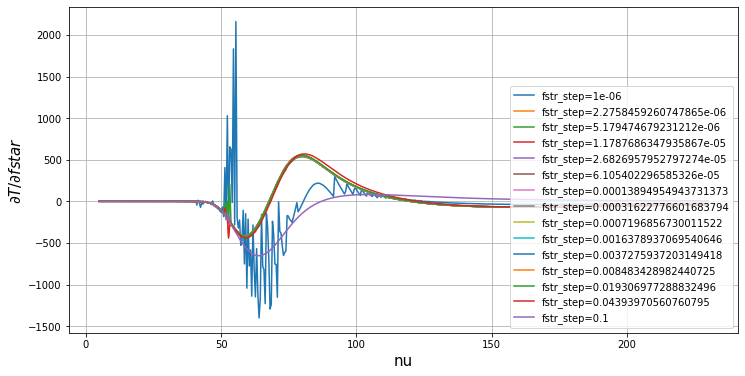

In [101]:
plt.subplots(figsize=(12,6))

for i,step in enumerate(stability):
#     print(i,step)
    if i>0:
        plt.plot(stability['nu'], stability[str(step)], label= "fstr_step=" + str(step))

plt.grid();plt.xlabel("nu",fontsize=15);plt.ylabel("$\partial T / \partial fstar$",fontsize=15)
plt.legend(loc='lower right')
plt.savefig("deriv_nu_fstar.pdf")

0 5.0
50 27.54509018036072
100 50.09018036072144
150 72.63527054108216
200 95.18036072144288
250 117.72545090180361
300 140.27054108216433
350 162.81563126252505
400 185.36072144288576
450 207.9058116232465


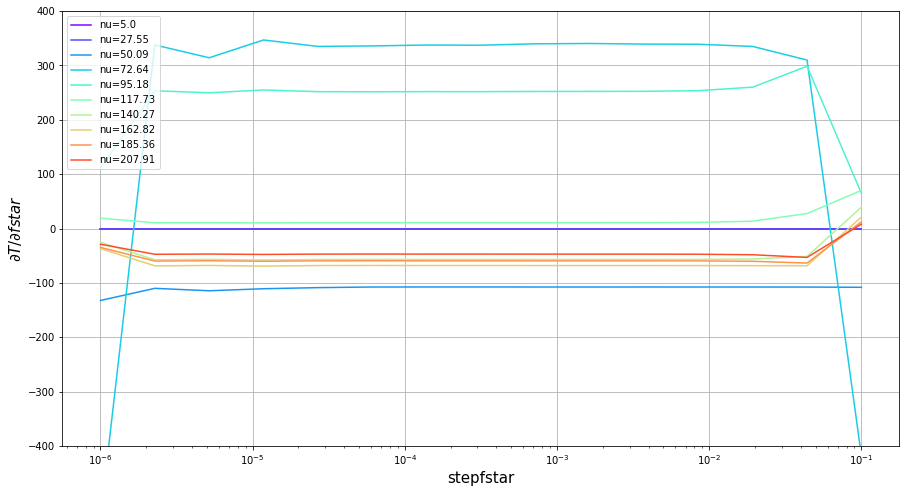

In [106]:
plt.subplots(figsize=(15,8))
cmap=plt.get_cmap("rainbow")

matmat = stability['nu']
for i,step in enumerate(stability):
#     print(i,step)
    if i>0:
        matmat = np.vstack((matmat,stability[str(step)]))

matmat = np.delete(matmat,0,0)

for j in range(len(stability['nu'])):
            if j%50 == 0:
                print(j, stability['nu'][j])
                color = cmap((stability['nu'][j]-min(stability['nu']))/(max(stability['nu'])-min(stability['nu'])))
                label = "nu="+str(np.round(stability['nu'][j],2))
                plt.plot(fstr_steps, matmat[:,j], label = label, color = color)
                
plt.grid();plt.xlabel("stepfstar",fontsize=15);plt.ylabel("$\partial T / \partial fstar$",fontsize=15)
plt.xscale("log"); plt.legend(loc='upper left');plt.ylim([-400, 400])
plt.savefig("deriv_step_fstar.pdf")

# Best stepsize Nion

In [125]:
# arr1 = np.logspace(-15,-1,15)
# arr2 = np.logspace(-1,0,6)
# fstr_steps = np.concatenate((arr1,arr2), axis=0)
Nion_steps = np.logspace(0,3,7)

fid_dict1 = {'Nion': 4000}
step_dict = {'Nion': 1000}
nu_test = np.linspace(5, 230, 500)
print(Nion_steps)

time0 = time.time()

stability = {}
for i, step in enumerate(Nion_steps):
    step_dict['Nion'] = step
    datadict1  = DataDict(nu_test,    fid_dict1, step_dict)
    derivdict1 = DerivDict(datadict1, fid_dict1, step_dict)
    if i==0:
        stability['nu'] = derivdict1['nu']
    stability[str(step)] = derivdict1['Nion']
    
print("--- %s seconds ---" % (time.time() - time0))

[   1.            3.16227766   10.           31.6227766   100.
  316.22776602 1000.        ]
--- 76.0216691493988 seconds ---


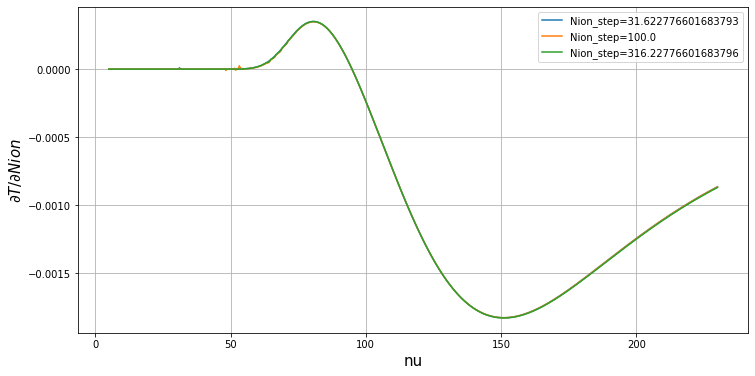

In [137]:
plt.subplots(figsize=(12,6))

for i,step in enumerate(stability):
#     print(i,step)
    if 7>i>3:
        plt.plot(stability['nu'], stability[str(step)], label= "Nion_step=" + str(step))

plt.grid();plt.xlabel("nu",fontsize=15);plt.ylabel("$\partial T / \partial Nion$",fontsize=15)
plt.legend(loc='upper right')
plt.savefig("deriv_nu_Nion.pdf")

0 5.0
25 16.27254509018036
50 27.54509018036072
75 38.81763527054108
100 50.09018036072144
125 61.362725450901806
150 72.63527054108216
175 83.90781563126252
200 95.18036072144288
225 106.45290581162325
250 117.72545090180361
275 128.99799599198397
300 140.27054108216433
325 151.5430861723447
350 162.81563126252505
375 174.0881763527054
400 185.36072144288576
425 196.63326653306615
450 207.9058116232465
475 219.17835671342687


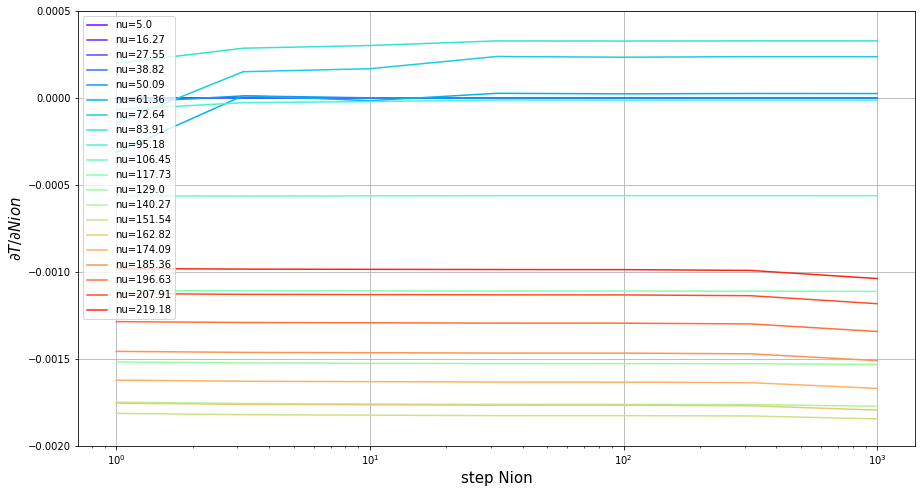

In [141]:
plt.subplots(figsize=(15,8))
cmap=plt.get_cmap("rainbow")

matmat = stability['nu']
for i,step in enumerate(stability):
#     print(i,step)
    if i>0:
        matmat = np.vstack((matmat,stability[str(step)]))

matmat = np.delete(matmat,0,0)

for j in range(len(stability['nu'])):
            if j%25 == 0:
                print(j, stability['nu'][j])
                color = cmap((stability['nu'][j]-min(stability['nu']))/(max(stability['nu'])-min(stability['nu'])))
                label = "nu="+str(np.round(stability['nu'][j],2))
                plt.plot(Nion_steps, matmat[:,j], label = label, color = color)
                
plt.grid();plt.xlabel("step Nion",fontsize=15);plt.ylabel("$\partial T / \partial Nion$",fontsize=15)
plt.xscale("log"); plt.legend(loc='upper left');plt.ylim([-.002, .0005])
plt.savefig("deriv_step_Nion.pdf")

# Best stepsize Nlw


In [148]:
# arr1 = np.logspace(-15,-1,15)
# arr2 = np.logspace(-1,0,6)
# fstr_steps = np.concatenate((arr1,arr2), axis=0)
Nlw_steps = np.logspace(-7,np.log10(8000),11)

fid_dict1 = {'Nlw': 9690.0}
step_dict = {'Nlw': 1000}
nu_test = np.linspace(5, 230, 500)
print(Nlw_steps)

time0 = time.time()

stability = {}
for i, step in enumerate(Nlw_steps):
    step_dict['Nlw'] = step
    datadict1  = DataDict(nu_test,    fid_dict1, step_dict)
    derivdict1 = DerivDict(datadict1, fid_dict1, step_dict)
    if i==0:
        stability['nu'] = derivdict1['nu']
    stability[str(step)] = derivdict1['Nlw']
    
print("--- %s seconds ---" % (time.time() - time0))

[1.00000000e-07 1.23114441e-06 1.51571657e-05 1.86606598e-04
 2.29739671e-03 2.82842712e-02 3.48220225e-01 4.28709385e+00
 5.27803164e+01 6.49801917e+02 8.00000000e+03]
--- 122.00800490379333 seconds ---


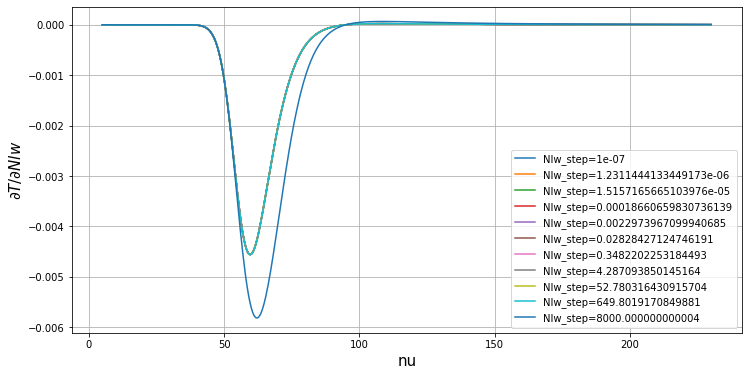

In [149]:
plt.subplots(figsize=(12,6))

for i,step in enumerate(stability):
#     print(i,step)
    if i>0:
        plt.plot(stability['nu'], stability[str(step)], label= "Nlw_step=" + str(step))

plt.grid();plt.xlabel("nu",fontsize=15);plt.ylabel("$\partial T / \partial Nlw$",fontsize=15)
plt.legend(loc='lower right')
plt.savefig("deriv_nu_Nlw.pdf")

0 5.0
25 16.27254509018036
50 27.54509018036072
75 38.81763527054108
100 50.09018036072144
125 61.362725450901806
150 72.63527054108216
175 83.90781563126252
200 95.18036072144288
225 106.45290581162325
250 117.72545090180361
275 128.99799599198397
300 140.27054108216433
325 151.5430861723447
350 162.81563126252505
375 174.0881763527054
400 185.36072144288576
425 196.63326653306615
450 207.9058116232465
475 219.17835671342687


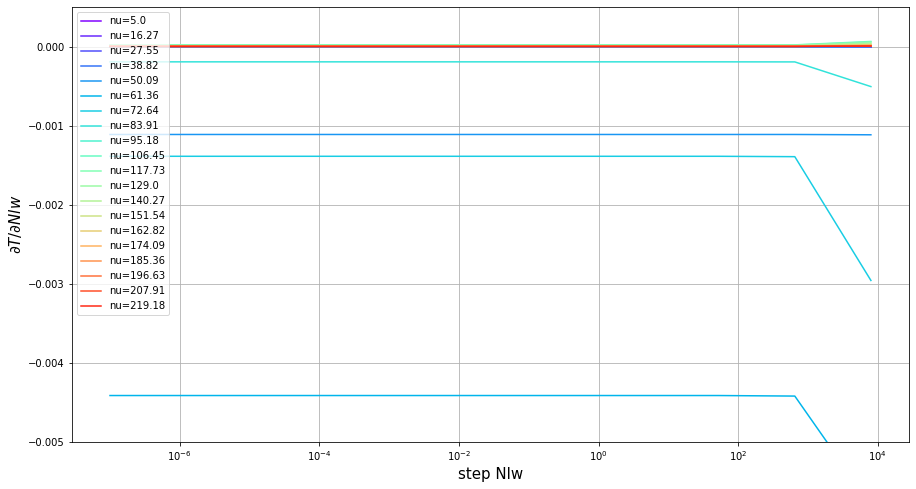

In [150]:
plt.subplots(figsize=(15,8))
cmap=plt.get_cmap("rainbow")

matmat = stability['nu']
for i,step in enumerate(stability):
#     print(i,step)
    if i>0:
        matmat = np.vstack((matmat,stability[str(step)]))

matmat = np.delete(matmat,0,0)

for j in range(len(stability['nu'])):
            if j%25 == 0:
                print(j, stability['nu'][j])
                color = cmap((stability['nu'][j]-min(stability['nu']))/(max(stability['nu'])-min(stability['nu'])))
                label = "nu="+str(np.round(stability['nu'][j],2))
                plt.plot(Nlw_steps, matmat[:,j], label = label, color = color)
                
plt.grid();plt.xlabel("step Nlw",fontsize=15);plt.ylabel("$\partial T / \partial Nlw$",fontsize=15)
plt.xscale("log"); plt.legend(loc='upper left');plt.ylim([-.005, .0005])
plt.savefig("deriv_step_Nlw.pdf")

# Best stepsize Tmin


In [159]:
# arr1 = np.logspace(-15,-1,15)
# arr2 = np.logspace(-1,0,6)
# fstr_steps = np.concatenate((arr1,arr2), axis=0)
Tmin_steps = np.logspace(-2,4,7)

fid_dict1 = {'Tmin': 10000}
step_dict = {'Tmin': 1000}
nu_test = np.linspace(5, 230, 500)
print(Tmin_steps)

time0 = time.time()

stability = {}
for i, step in enumerate(Tmin_steps):
    step_dict['Tmin'] = step
    datadict1  = DataDict(nu_test,    fid_dict1, step_dict)
    derivdict1 = DerivDict(datadict1, fid_dict1, step_dict)
    if i==0:
        stability['nu'] = derivdict1['nu']
    stability[str(step)] = derivdict1['Tmin']
    
print("--- %s seconds ---" % (time.time() - time0))

[1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04]
--- 70.45204973220825 seconds ---


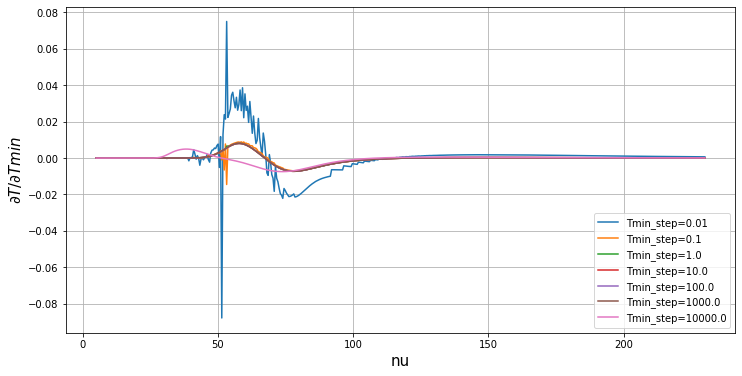

In [160]:
plt.subplots(figsize=(12,6))

for i,step in enumerate(stability):
#     print(i,step)
    if i>0:
        plt.plot(stability['nu'], stability[str(step)], label= "Tmin_step=" + str(step))

plt.grid();plt.xlabel("nu",fontsize=15);plt.ylabel("$\partial T / \partial Tmin$",fontsize=15)
plt.legend(loc='lower right')
plt.savefig("deriv_nu_Tmin.pdf")

0 5.0
25 16.27254509018036
50 27.54509018036072
75 38.81763527054108
100 50.09018036072144
125 61.362725450901806
150 72.63527054108216
175 83.90781563126252
200 95.18036072144288
225 106.45290581162325
250 117.72545090180361
275 128.99799599198397
300 140.27054108216433
325 151.5430861723447
350 162.81563126252505
375 174.0881763527054
400 185.36072144288576
425 196.63326653306615
450 207.9058116232465
475 219.17835671342687


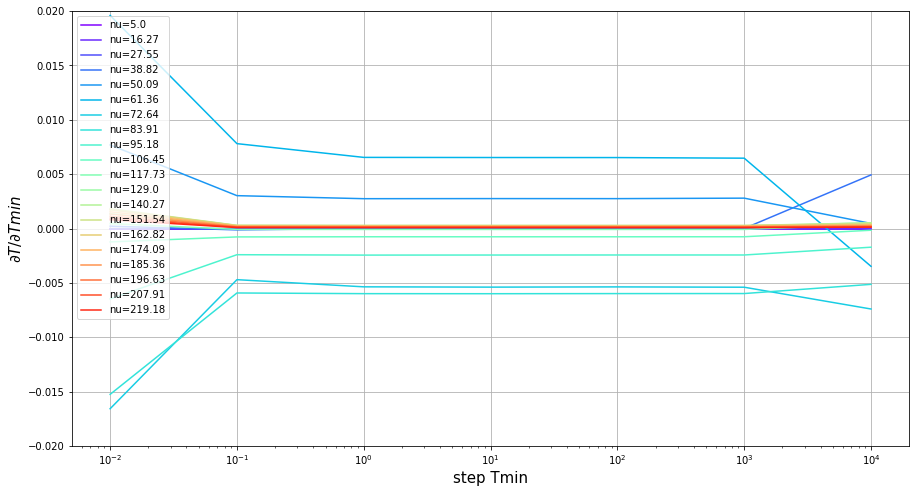

In [166]:
plt.subplots(figsize=(15,8))
cmap=plt.get_cmap("rainbow")

matmat = stability['nu']
for i,step in enumerate(stability):
#     print(i,step)
    if i>0:
        matmat = np.vstack((matmat,stability[str(step)]))

matmat = np.delete(matmat,0,0)

for j in range(len(stability['nu'])):
            if j%25 == 0:
                print(j, stability['nu'][j])
                color = cmap((stability['nu'][j]-min(stability['nu']))/(max(stability['nu'])-min(stability['nu'])))
                label = "nu="+str(np.round(stability['nu'][j],2))
                plt.plot(Tmin_steps, matmat[:,j], label = label, color = color)
                
plt.grid();plt.xlabel("step Tmin",fontsize=15);plt.ylabel("$\partial T / \partial Tmin$",fontsize=15)
plt.xscale("log"); plt.legend(loc='upper left');plt.ylim([-.02, .02])
plt.savefig("deriv_step_Tmin.pdf")